In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch 
import torchvision

%matplotlib inline 

## Data Preparation 
> In this case the data was already preprocessed 

In [3]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.ToTensor(),
    
])

train_data = torchvision.datasets.Food101(
                                        root = "data" ,
                                        split = "train" , 
                                        transform= train_transform ,
                                        download=False 
                                        )
test_data = torchvision.datasets.Food101(
                                        root = "data" ,
                                        split = "test" , 
                                        transform= train_transform ,
                                        download=False 
                                        )



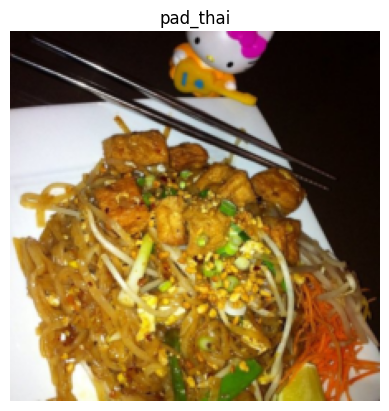

In [4]:
import random

img , label = train_data[random.randint(1,10000)]
import matplotlib.pyplot as plt

classes = train_data.classes

img = img.detach().cpu()   # remove grad + move to cpu
img = img.permute(1, 2, 0)          # (H, W, C)

plt.imshow(img)
plt.axis("off")
plt.title(f"{classes[label]}")
plt.show()


In [5]:
from collections import Counter

print(f"Train data value counts of each label : \n{dict(Counter(train_data._labels))}")
print(f"Test data value counts of each label : \n{dict(Counter(test_data._labels))}")


Train data value counts of each label : 
{23: 750, 54: 750, 85: 750, 86: 750, 77: 750, 92: 750, 73: 750, 4: 750, 48: 750, 39: 750, 96: 750, 70: 750, 78: 750, 81: 750, 80: 750, 7: 750, 6: 750, 0: 750, 26: 750, 84: 750, 71: 750, 93: 750, 1: 750, 64: 750, 45: 750, 25: 750, 14: 750, 36: 750, 8: 750, 20: 750, 47: 750, 13: 750, 27: 750, 35: 750, 21: 750, 98: 750, 90: 750, 65: 750, 87: 750, 2: 750, 33: 750, 62: 750, 72: 750, 46: 750, 5: 750, 68: 750, 83: 750, 50: 750, 18: 750, 30: 750, 11: 750, 57: 750, 38: 750, 59: 750, 74: 750, 51: 750, 94: 750, 24: 750, 28: 750, 41: 750, 3: 750, 44: 750, 31: 750, 52: 750, 82: 750, 43: 750, 91: 750, 42: 750, 60: 750, 15: 750, 10: 750, 40: 750, 89: 750, 37: 750, 53: 750, 32: 750, 99: 750, 95: 750, 16: 750, 34: 750, 29: 750, 97: 750, 22: 750, 9: 750, 55: 750, 63: 750, 100: 750, 88: 750, 12: 750, 56: 750, 76: 750, 19: 750, 75: 750, 79: 750, 17: 750, 58: 750, 67: 750, 49: 750, 61: 750, 66: 750, 69: 750}
Test data value counts of each label : 
{23: 250, 54: 250,

## Loading the model from torchvision

In [6]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")

In [7]:
## Freezing all the pretrained layers 
for param in model.parameters() :
    param.requires_grad = False

In [8]:
## Replace the model classifier head 
num_classes = 101

model.fc = torch.nn.Linear(model.fc.in_features , num_classes)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [67]:
from tqdm import tqdm
def Train_loop(model, data_loader, accuracy_fn, optimizer, loss_fn, device):
    model.train()
    model.to(device)

    accuracy_fn.reset()
    train_loss = 0.0

    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = logits.argmax(dim=1)
        accuracy_fn.update(preds, labels)

    train_loss /= len(data_loader)
    train_acc = accuracy_fn.compute().item()

    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        
def Test_loop(model, data_loader, loss_fn, accuracy_fn, device, max_batches=None):
    model.eval()
    accuracy_fn.reset()
    test_loss = 0.0

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            if max_batches is not None and batch_idx >= max_batches:
                break

            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)

            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            accuracy_fn.update(preds, y)

    test_loss /= (batch_idx + 1)
    test_acc = accuracy_fn.compute().item()

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    return test_loss, test_acc



In [52]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(dataset=train_data ,
                               batch_size=32 , 
                               shuffle= True,
                               num_workers=6,
                               pin_memory=False)

test_data_loader = DataLoader(dataset=test_data ,
                               batch_size=32 , 
                               shuffle= True ,
                               num_workers=6,
                               pin_memory=False)

In [53]:
from torchmetrics import Accuracy
# Setting up accuracy function 
accuracy_fn = Accuracy(task="multiclass" ,num_classes=101).to(device)

# Setting up loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Setting up optimizer 
# optimizer = torch.optim.Adam(params= filter(lambda p:p.requires_grad , model.parameters()) ,
#                              lr=1e-3)

In [54]:
# from tqdm import tqdm
# epochs = 2
# for epoch in tqdm(range(epochs)):
#     Train_loop(
#         model=model,
#         data_loader=train_data_loader,
#         loss_fn=loss_fn ,
#         optimizer=optimizer ,
#         device=device,
#         accuracy_fn=accuracy_fn ,
#         test_data_loader=test_data_loader
#     )
#     Test_loop(
#         model=model, 
#         data_loader=test_data_loader,
#         loss_fn=loss_fn ,
#         accuracy_fn=accuracy_fn ,
#         device=device  
#     )
    


### Unfreezing the last to layer of the model to fine tune 

In [55]:
for name , param in model.named_parameters() :
    if name == "layer4" :
        param.requires_grad = True

In [56]:
optimizer  =  torch.optim.Adam([
    {"params" : model.layer4.parameters() , "lr" : 1e-5} ,
    {"params" : model.fc.parameters() , "lr" : 1e-3}
]
)

In [57]:
from tqdm import tqdm
epochs = 10
for epoch in range(epochs):
    print(f"Epoch : {epoch}")
    Train_loop(
        model=model,
        data_loader=train_data_loader,
        loss_fn=loss_fn ,
        optimizer=optimizer ,
        device=device,
        accuracy_fn=accuracy_fn ,
    )
    Test_loop(
        model=model, 
        data_loader=test_data_loader,
        loss_fn=loss_fn ,
        accuracy_fn=accuracy_fn ,
        device=device  ,
        max_batches=50
    )
    


Epoch : 0


100%|██████████| 2368/2368 [03:43<00:00, 10.61it/s]


Train loss: 0.6370 | Train acc: 0.8112


  6%|▋         | 50/790 [00:26<06:35,  1.87it/s] 


Test loss: 1.6217 | Test acc: 0.6131
Epoch : 1


100%|██████████| 2368/2368 [03:45<00:00, 10.48it/s]


Train loss: 0.6228 | Train acc: 0.8150


  6%|▋         | 50/790 [00:26<06:38,  1.86it/s] 


Test loss: 1.5694 | Test acc: 0.6112
Epoch : 2


100%|██████████| 2368/2368 [03:41<00:00, 10.68it/s]


Train loss: 0.6175 | Train acc: 0.8164


  6%|▋         | 50/790 [00:27<06:43,  1.83it/s] 


Test loss: 1.6588 | Test acc: 0.6181
Epoch : 3


100%|██████████| 2368/2368 [03:29<00:00, 11.31it/s]


Train loss: 0.6223 | Train acc: 0.8139


  6%|▋         | 50/790 [00:25<06:20,  1.94it/s] 


Test loss: 1.6025 | Test acc: 0.6375
Epoch : 4


100%|██████████| 2368/2368 [03:25<00:00, 11.54it/s]


Train loss: 0.6101 | Train acc: 0.8177


  6%|▋         | 50/790 [00:25<06:18,  1.95it/s] 


Test loss: 1.5793 | Test acc: 0.6313
Epoch : 5


100%|██████████| 2368/2368 [03:30<00:00, 11.24it/s]


Train loss: 0.6084 | Train acc: 0.8181


  6%|▋         | 50/790 [00:27<06:44,  1.83it/s] 


Test loss: 1.6010 | Test acc: 0.6313
Epoch : 6


100%|██████████| 2368/2368 [03:42<00:00, 10.65it/s]


Train loss: 0.6043 | Train acc: 0.8171


  6%|▋         | 50/790 [00:27<06:40,  1.85it/s] 


Test loss: 1.6977 | Test acc: 0.6112
Epoch : 7


100%|██████████| 2368/2368 [03:35<00:00, 10.99it/s]


Train loss: 0.6014 | Train acc: 0.8202


  6%|▋         | 50/790 [00:25<06:22,  1.94it/s] 


Test loss: 1.6024 | Test acc: 0.6275
Epoch : 8


100%|██████████| 2368/2368 [03:27<00:00, 11.42it/s]


Train loss: 0.6006 | Train acc: 0.8191


  6%|▋         | 50/790 [00:26<06:24,  1.92it/s] 


Test loss: 1.7306 | Test acc: 0.6031
Epoch : 9


100%|██████████| 2368/2368 [03:23<00:00, 11.65it/s]


Train loss: 0.5930 | Train acc: 0.8203


  6%|▋         | 50/790 [00:25<06:17,  1.96it/s] 

Test loss: 1.6804 | Test acc: 0.6125


In [58]:
Test_loop(
        model=model, 
        data_loader=test_data_loader,
        loss_fn=loss_fn ,
        accuracy_fn=accuracy_fn ,
        device=device  ,
    )

100%|██████████| 790/790 [01:17<00:00, 10.15it/s]

Test loss: 1.7201 | Test acc: 0.6176


In [62]:
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


In [60]:
torch.save(model.state_dict(), "best_model.pt")

In [63]:
optimizer = torch.optim.AdamW([
    {"params": model.layer3.parameters(), "lr": 1e-5},
    {"params": model.layer4.parameters(), "lr": 3e-5},
    {"params": model.fc.parameters(),     "lr": 3e-4},
], weight_decay=1e-4)


In [65]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",        # because we monitor accuracy
    patience=3,        # wait 3 epochs with no improvement
    factor=0.3,        # reduce LR to 30%
)


In [68]:
%%time
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    Train_loop(
        model=model,
        data_loader=train_data_loader,
        accuracy_fn=accuracy_fn,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device
    )

    val_loss, val_acc = Test_loop(
        model=model,
        data_loader=test_data_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device , 
        max_batches = 50
        
    )


    scheduler.step(val_acc)


    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved new best model")



Epoch 1/10


100%|██████████| 2368/2368 [05:27<00:00,  7.22it/s]


Train loss: 0.1937 | Train acc: 0.9439
Test loss: 1.4229 | Test acc: 0.6988
Saved new best model

Epoch 2/10


100%|██████████| 2368/2368 [05:25<00:00,  7.27it/s]


Train loss: 0.0966 | Train acc: 0.9738
Test loss: 1.4601 | Test acc: 0.6862

Epoch 3/10


100%|██████████| 2368/2368 [05:26<00:00,  7.25it/s]


Train loss: 0.0583 | Train acc: 0.9856
Test loss: 1.4305 | Test acc: 0.7219
Saved new best model

Epoch 4/10


100%|██████████| 2368/2368 [05:28<00:00,  7.22it/s]


Train loss: 0.0426 | Train acc: 0.9896
Test loss: 1.2990 | Test acc: 0.7256
Saved new best model

Epoch 5/10


100%|██████████| 2368/2368 [05:33<00:00,  7.09it/s]


Train loss: 0.0349 | Train acc: 0.9912
Test loss: 1.5303 | Test acc: 0.7113

Epoch 6/10


100%|██████████| 2368/2368 [05:24<00:00,  7.30it/s]


Train loss: 0.0275 | Train acc: 0.9934
Test loss: 1.5237 | Test acc: 0.7094

Epoch 7/10


  0%|          | 0/2368 [00:06<?, ?it/s]


KeyboardInterrupt: 